# Pneumonia Prediction using Convulational Neural Network

The images trained, tested and validated for the neural network are chest X-Ray images. The implementation of clinical-decision support algorithms for medical imaging faces challenges with reliability and interpretability. Here, I establish a diagnostic tool based on a deep-learning framework for the screening of patients with common treatable blinding retinal diseases.

![](http://miro.medium.com/max/1838/1*t-_EXQ3tlb8KOx6H7HN09A.jpeg)

* The **normal** chest X-ray depicts clear lungs without any areas of abnormal opacification in the image. 
* **Bacterial pneumonia** typically exhibits a focal lobar consolidation around upper lobes (white arrows)
* **Viral pneumonia** manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs.

### Downloading Dataset Direct from Kaggle to Google Colab using API Command

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"alishbasiddique07","key":"44a11a48faa0a3f2ab39c9e630b92ef3"}'}

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

404 - Not Found


In [ ]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [ ]:
! kaggle datasets list

ref                                                  title                                       size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------  -----------------------------------------  -----  -------------------  -------------  ---------  ---------------  
iamsouravbanerjee/house-rent-prediction-dataset      House Rent Prediction Dataset               82KB  2022-08-20 13:49:03           4896        165  1.0              
deepcontractor/mcdonalds-india-menu-nutrition-facts  McDonald's India : Menu Nutrition Dataset    5KB  2022-07-28 17:08:52           4451        168  0.9411765        
arianazmoudeh/airbnbopendata                         Airbnb Open Data                            10MB  2022-08-01 15:58:10           2749         91  0.9705882        
digitalbro/usa-childrens-hospitals                   USA Childrens Hospitals                     18KB  2022-08-24 02:20:09            292         26  1.0       

# **Importing Libraries**

In [ ]:
!pip install gradio

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2 as cv
import os
import numpy as np
import pandas as pd
import gradio

# **Data Preprocessing**

Getting dataset for training, validation and testing

In [ ]:
from numpy.core.fromnumeric import resize
lables = ['PNEUMONIA', 'NORMAL']
image_size = 150
def get_data_images(data_dir):
    data = []
    for label in lables:
        path = os.path.join(data_dir, label)
        class_number = lables.index(label)
        for image in os.listdir(path):
            try:
                 image_array = cv.imread(os.path.join(path, image), cv.IMREAD_GRAYSCALE)
                 resized_array = cv.resize(image_array, (image_size, image_size))
                 data.append([resized_array, class_number])
            except Exception as ex:
                 print(ex) 
    return np.array(data)


In [ ]:
train = get_data_images('../content/chest_xray/train')
test = get_data_images('../content/chest_xray/test')
val = get_data_images('../content/chest_xray/val')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()


**Seperating x and y labels for training, testing and validation**

In [ ]:
x_train = []
y_train = []

x_test = []
y_test = []

x_val = []
y_val = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [ ]:
positives = []
negatives = []
for i in range(len(y_train)):
    if y_train[i]:
        positives.append(x_train[i])
    else:
        negatives.append(x_train[i])

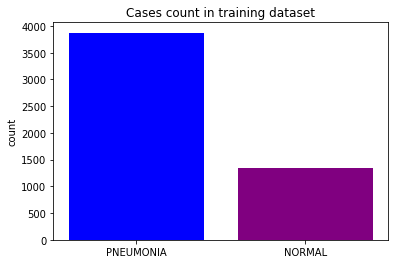

In [ ]:
plt.bar(lables, [len(negatives), len(positives)], color=["blue", "purple"])
plt.title("Cases count in training dataset")
plt.ylabel("count")
plt.show()

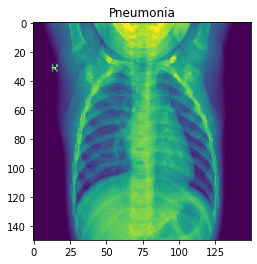

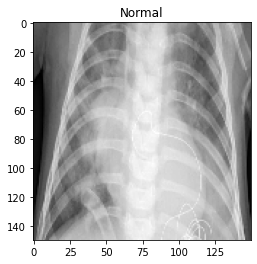

In [ ]:
plt.imshow(positives[0])
plt.title("Pneumonia")
plt.show()

plt.imshow(negatives[4], cmap="gray")
plt.title("Normal")
plt.show()

**Performing a grayscale NORMALIZATION to reduce the effect of illumination's differences**

In [ ]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

**Resizing the data for CNN training and testing**

In [ ]:
x_train = x_train.reshape(-1, image_size, image_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, image_size, image_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, image_size, image_size, 1)
y_test = np.array(y_test)

In [ ]:
x_test[0].shape

(150, 150, 1)

In [ ]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_val = y_val.reshape(-1,1)

#**Data Augmentation**

We can expand our dataset to avoid overfitting problem. This can be done by changing the training data with small transformations to reproduce the variations.

Popular Augmentations used by people are grayscales, horizontal flips, vertical flips, rotations, random crops, color jitters, translations, and much more. We can eaisly double or triple the number of training examples by applying few of these transformations to our training dataset and create a very fast and robust model.

In [ ]:
from re import T
data_generation = ImageDataGenerator(
                featurewise_center=False,
                samplewise_center=False,
                featurewise_std_normalization=False,
                samplewise_std_normalization=False,
                zca_whitening=False,
                rotation_range=30, # randomly rotate image in the range (degrees, 0 to 100)
                zoom_range= 0.2, # randomly zoom range
                width_shift_range= 0.1, # randomly shift images horizontally (fraction of total width)
                height_shift_range=0.1, # randomly shift images vertically (fraction of total height)
                horizontal_flip=True, # randomly flip images
                vertical_flip=False) # randomly flip images


data_generation.fit(x_train)                

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150, 150, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64, (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64, (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150, 150, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(128, (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(256, (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [ ]:
model.compile(optimizer = "rmsprop",
              loss = "binary_crossentropy",
              metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience = 2,
                                            verbose=1,
                                            factor=0.3,
                                            min_lr=0.000001)

In [ ]:
history = model.fit(data_generation.flow(x_train, y_train, batch_size = 32),
                    epochs = 10,
                    validation_data = data_generation.flow(x_val, y_val),
                    callbacks = learning_rate_reduction) 


Epoch 1/10
163/163 [==============================] - 353s 2s/step - loss: 0.4938 - accuracy: 0.8372 - val_loss: 37.0905 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 356s 2s/step - loss: 0.2690 - accuracy: 0.8992 - val_loss: 29.9682 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.2329 - accuracy: 0.9164
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 338s 2s/step - loss: 0.2329 - accuracy: 0.9164 - val_loss: 44.0323 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 338s 2s/step - loss: 0.1599 - accuracy: 0.9454 - val_loss: 1.3875 - val_accuracy: 0.6250 - lr: 3.0000e-04
Epoch 5/10
163/163 [==============================] - 349s 2s/step - loss: 0.1503 - accuracy: 0.9496 - val_loss: 0.6931 - val_accuracy: 0.6875 - lr: 3.0000e-04


In [ ]:
model.save_weights('kaggle/saved_model_ai/pneumoniadetection')
model.save('model.h5')

### Evaluation Metrics

In [ ]:
print("Loss of the model is -> ", model.evaluate(x_test, y_test)[0])
print("Accuracy of the model is -> ", model.evaluate(x_test, y_test)[1]*100, "%")

In [ ]:
epochs = list(range(10)) 
fig, ax = plt.subplots(1,2)
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs, train_accuracy, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_accuracy, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'g-o', label = 'Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
predictions = model.predict(x_test)
for i in range(len(predictions)):
    predictions[i] = 1 if predictions[i]>0.5 else 0

In [ ]:
print(classification_report(y_test,
                            predictions,
                            target_names = ['Pneumonia (Class 0)', 'Normal (Class 1)']))

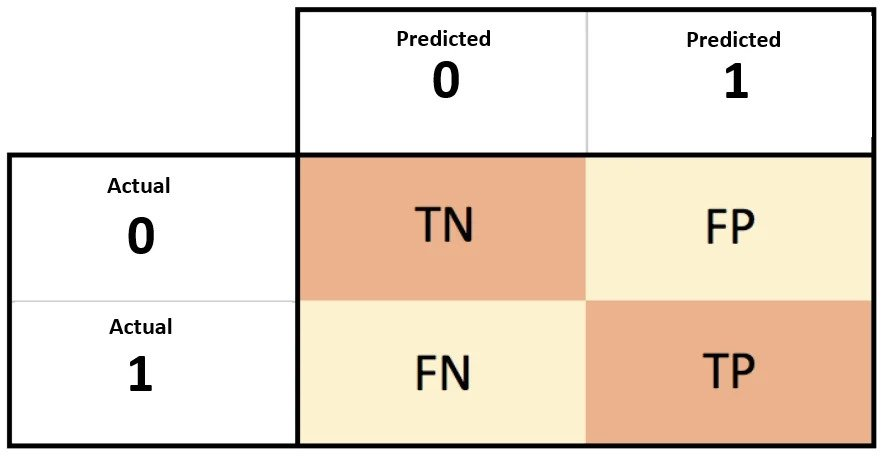

In [ ]:
cm = confusion_matrix(y_test, predictions)
cm = pd.DataFrame(cm, index = ['0','1'], columns = ['0','1'])
cm

,0,1
0,347,43
1,21,213


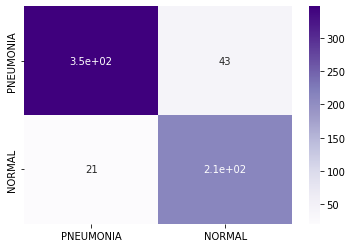

In [ ]:
sns.heatmap(cm, cmap="Purples", annot=True, xticklabels =lables, yticklabels = lables)
plt.show()

In [ ]:
def pneumoniaPrediction(image):
    image = np.array(image)/255
    image = image.reshape(-1, 150, 150, 1)
    isPneumonic = model.predict(image)[0]
    imageClass = 'Normal' if isPneumonic<0.5 else "Pneumonia"
    return imageClass

In [ ]:
pr = model.predict(x_test)
for i in range(len(pr)):
    if pr[i]>0.5:
        pr[i]=1
    else:
        pr[i]=0

In [ ]:
interface = gradio.Interface(fn = pneumoniaPrediction,
                            title = "Pneumonia Detection using Chest X-Ray",
                            inputs = img,
                            outputs = label,
                            interpretation = "default")
interface.launch(debug=True, share=True)

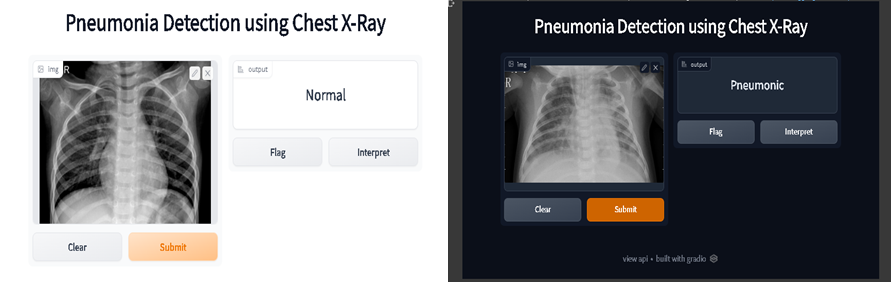